## Localization vs Non-localization Rates by Imaging Modality

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
preop_imaging_df = pd.read_excel('Data/Clean_imaging_data.xlsx')

In [4]:
# initalize the modalities 
modalities = ['SPECT/CT', '4D CT Scan', 'Ultrasound', 'Sestamibi', 'MRI']

# create dictionaries to store the counts 
non_localizing_counts = {}
localizing_counts = {}
non_localizing_rates = {}
localizing_rates = {}

In [7]:
# iterate through each modality 
for modality in modalities:
    
    # calculate non-localizing
    non_localizing_count = preop_imaging_df[preop_imaging_df[modality] == 'Non-localizing'].shape[0]
    # store this in the respective dictionary
    non_localizing_counts[modality] = non_localizing_count
    
    # count the localized scans (not non-localizing or no scan)
    localizing_count = preop_imaging_df[
            preop_imaging_df[modality].notnull() & 
            (preop_imaging_df[modality] != 'Non-localizing') & 
            (preop_imaging_df[modality] != 'No Scan')
        ].shape[0]
    # add to the respective dictionary 
    localizing_counts[modality] = localizing_count

    # calculate total scans 
    total_scans = non_localizing_count + localizing_count
    
    # Calculate non-localization rate
    non_localizing_rates[modality] = round((non_localizing_count / total_scans * 100) if total_scans > 0 else 0, 2)
    localizing_rates[modality] = round((localizing_count / total_scans * 100) if total_scans > 0 else 0, 2)

print(localizing_rates)
print(non_localizing_rates)

{'SPECT/CT': 77.39, '4D CT Scan': 75.88, 'Ultrasound': 53.79, 'Sestamibi': 64.94, 'MRI': 53.33}
{'SPECT/CT': 22.61, '4D CT Scan': 24.12, 'Ultrasound': 46.21, 'Sestamibi': 35.06, 'MRI': 46.67}


In [15]:
# convert to a dataframe for better output 
# Convert to DataFrame
summary_df = pd.DataFrame({
    'Non-localizing': non_localizing_counts,
    'Localizing': localizing_counts,
    'Non-localization Rate (%)': non_localizing_rates,
    'Localization Rate (%)': localizing_rates
})

summary_df

,Non-localizing,Localizing,Non-localization Rate (%),Localization Rate (%)
SPECT/CT,52,178,22.61,77.39
4D CT Scan,55,173,24.12,75.88
Ultrasound,67,78,46.21,53.79
Sestamibi,61,113,35.06,64.94
MRI,7,8,46.67,53.33


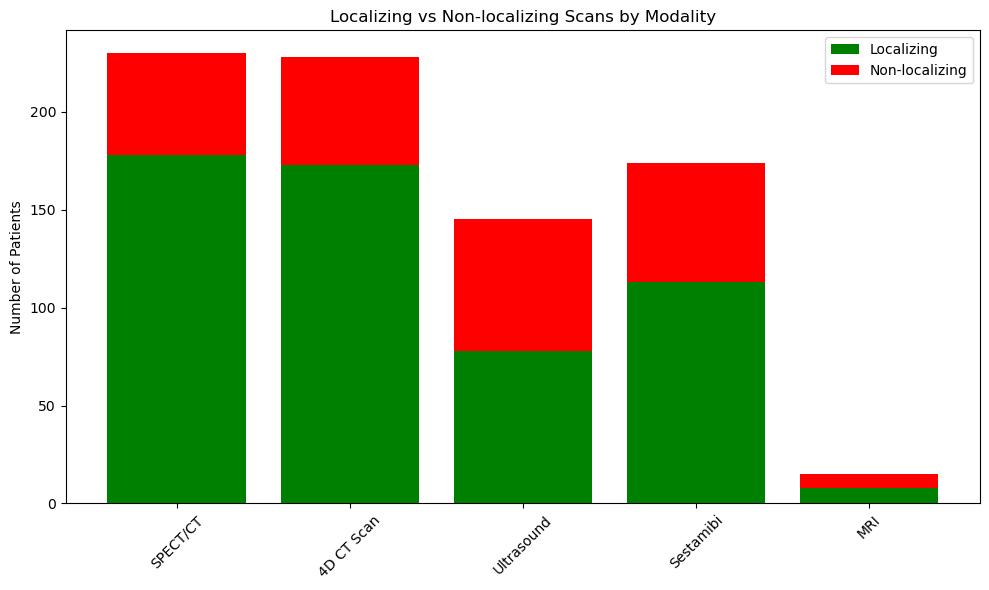

In [16]:
# Convert to series 
localizing_series = pd.Series(localizing_counts)
non_localizing_series = pd.Series(non_localizing_counts)

# initialize figure size
plt.figure(figsize=(10,6))

# Plot directly from the Series
plt.bar(localizing_series.index, localizing_series, label='Localizing', color='green')
plt.bar(non_localizing_series.index, non_localizing_series, 
        bottom=localizing_series, label='Non-localizing', color='red')

plt.ylabel('Number of Patients')
plt.title('Localizing vs Non-localizing Scans by Modality')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()